# WAIC&WBIC with pystan - 補足：iterが少ない場合

- "WAIC&WBIC with pystan2.ipynb"の結果、重畳したLorenz関数型ピークの本数選択にはWBICが適しており、WAICでは選択を誤る可能性が示唆された。
- 参考として、MCMCのiterが少ない場合の結果も示しておく。
  - データは <https://github.com/narrowlyapplicable/peak_separation_whth_WBIC> で作成した信号ピーク模擬データを使用した。  


## 1. 必要なライブラリのインポート

- pythonのバージョンは3.6.6
- 使用ライブラリ群は以下
  - numpy 1.15.1
  - pandas 0.23.4
  - pystan 2.17.1.0
  - matplotlib 2.2.2
  - seaborn 0.9.0

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as sct
from pystan import StanModel
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
sns.set_palette('deep')

## 2. データの作成

- Lorenz関数(Cauchy分布の確率密度関数)型のピーク信号が、複数個重畳して測定される状況を考える。
- scipy.statsを用いて3本のLorenz関数を重ね、さらにガウスノイズを付加したデータを作成した。
  - 2つのピークが重畳 & 1本のショルダーピークが存在する、という状況を想定している。

In [2]:
np.random.seed(1)
x = np.arange(-10, 10.5, 0.5)
k_true = 3
peak1 = sct.cauchy.pdf(x = x, loc = 0, scale = 1.0)
# peak2 = 0.16 * sct.cauchy.pdf(x = x, loc = 1, scale = 0.4)
peak3 = 0.09 * sct.cauchy.pdf(x = x, loc = -0.7, scale = 0.3)
peak4 = 0.36 * sct.cauchy.pdf(x = x, loc = 3.0, scale = 0.6)

data = pd.DataFrame(data={"x":x, "y":peak1+peak3+peak4+np.random.normal(size=x.shape[0], scale=0.01)})

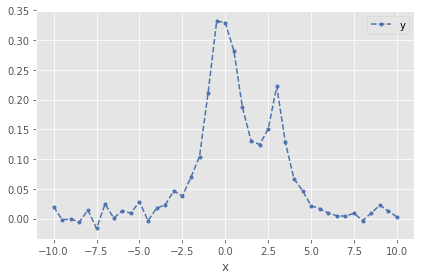

In [3]:
data.plot(x="x", marker=".", linestyle="--") #pandasのplot使用
plt.tight_layout()

## 3. モデルの定義
- モデルには以下の事前知識を仮定する。
  - ピークの幅には上限があり、Cauchy分布確率密度関数のscaleは高々2程度である。
  - 観測ノイズは正規分布に従い、そのsdは高々0.05である。
- これらの条件を反映し、弱情報事前分布として半t分布を用いる。

### 3.1. WAIC用のstanコード

In [4]:
code_waic = """
data {
  int N;
  int K;
  vector[N] X;
  vector[N] Y;
}

parameters {
  vector[K] mu;
  vector<lower=0>[K] sigma;
  real<lower=0> s_mu;
  real<lower=0> s_noise;
}

model {
  mu ~ normal(0, s_mu);
  sigma ~ student_t(4, 0, 2);
  s_noise ~ student_t(4, 0, 0.05);
  for (n in 1:N) {
    vector[K] line;
    for (k in 1:K){
      line[k] = log(sigma[k]^2) + cauchy_lpdf(X[n] | mu[k], sigma[k]);
    }
    target += normal_lpdf(Y[n] | exp(log_sum_exp(line)), s_noise);
  }
}

generated quantities {
  vector[N] log_likelihood;
  for(n in 1:N){
    vector[K] line;
    for (k in 1:K){
      line[k] = log(sigma[k]^2) + cauchy_lpdf(X[n] | mu[k], sigma[k]);
    }
    log_likelihood[n] = normal_lpdf(Y[n] | exp(log_sum_exp(line)), s_noise);
  }
}

"""

In [5]:
# コンパイル済みのモデルがあれば読み込み。なければコンパイルし保存。
try:
    with open('./model_peakwaic.pkl', "rb") as f:
        stanmodel_waic = pickle.load(f)
except FileNotFoundError:
    stanmodel_waic = StanModel(model_code=code_waic, model_name="model_peakwaic")
    with open('./model_peakwaic.pkl', "wb") as f:
        pickle.dump(stanmodel_waic, f)

## 3.2. WBIC用のstanコード
- modelブロックでは、target記法により逆温度 $1/log(N)$ [Nはデータ数] の事後分布を定義している。
- generated quantitiesブロックにおいて、上記事後分布の下での対数尤度を算出している。
- stanコードは以前の実装例 <https://github.com/narrowlyapplicable/peak_separation_whth_WBIC/blob/master/wbic-mix-cauchy_lpdf.stan> そのまま。


In [6]:
code_wbic = """
data {
  int N;
  int K;
  vector[N] X;
  vector[N] Y;
}

parameters {
  vector[K] mu;
  vector<lower=0>[K] sigma;
  real<lower=0> s_mu;
  real<lower=0> s_noise;
}

model {
  mu ~ normal(0, s_mu);
  sigma ~ student_t(4, 0, 2);
  s_noise ~ student_t(4, 0, 0.05);
  for (n in 1:N) {
    vector[K] line;
    for (k in 1:K){
      line[k] = log(sigma[k]^2) + cauchy_lpdf(X[n] | mu[k], sigma[k]);
    }
    target += 1/log(N) * normal_lpdf(Y[n] | exp(log_sum_exp(line)), s_noise);
  }
}

generated quantities {
  vector[N] log_likelihood;
  for(n in 1:N){
    vector[K] line;
    for (k in 1:K){
      line[k] = log(sigma[k]^2) + cauchy_lpdf(X[n] | mu[k], sigma[k]);
    }
    log_likelihood[n] = normal_lpdf(Y[n] | exp(log_sum_exp(line)), s_noise);
  }
}

"""

In [7]:
# コンパイル済みのモデルがあれば読み込み。なければコンパイルし保存。
try:
    with open('./model_peakwbic.pkl', "rb") as f:
        stanmodel_wbic = pickle.load(f)
except FileNotFoundError:
    stanmodel_wbic = StanModel(model_code=code_wbic, model_name="model_peakwbic")
    with open('./model_peakwbic.pkl', "wb") as f:
        pickle.dump(stanmodel_wbic, f)

## 4. MCMC実行 & IC算出
- ピーク本数は少なくとも2本以上であることから、ピーク本数候補は2,3,4,5の４通りとした。
- この４通りのについて、WAICとWBICを算出した。
  - こちらもWBICについては以前の実装例そのまま。
  - WAICについては導出がやや煩雑となるため、waic()関数を作成している。

### 4.1. WAIC算出

In [8]:
def waic(samples):
    tE = - np.mean(np.log(np.mean(np.exp(samples), axis=0)))
    fVar = np.sum(np.mean(samples**2, axis=0) - np.mean(samples, axis=0)**2)
    waic = tE + fVar/samples.shape[0]
    return waic

In [9]:
dict_waic = {}
for k_cand in [2,3,4,5]:
    #pystan用にデータを辞書型にまとめる
    standata = {"N":data.shape[0], "K":k_cand,  "X":data["x"], "Y":data["y"]}
    fit = stanmodel_waic.sampling(data = standata, iter=1000, warmup=400, seed=1234)
    ms = fit.extract()
    dict_waic[k_cand] = waic(ms["log_likelihood"])

//anaconda/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [10]:
df_waic = pd.DataFrame(data={"n_peak":list(dict_waic.keys()), "WAIC":list(dict_waic.values())})

### 4.2. WBIC算出

In [11]:
dict_wbic = {}
for k_cand in [2,3,4,5]:
    #pystan用にデータを辞書型にまとめる
    standata = {"N":data.shape[0], "K":k_cand,  "X":data["x"], "Y":data["y"]}
    fit = stanmodel_wbic.sampling(data = standata, iter=1000, warmup=400, seed=1234)
    ms = fit.extract()
    dict_wbic[k_cand] = - np.mean(np.sum(ms["log_likelihood"], axis=1))

//anaconda/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [12]:
df_wbic = pd.DataFrame(data={"n_peak":list(dict_wbic.keys()), "WBIC":list(dict_wbic.values())})

## 5. 結果

- 算出されたWAIC, WBIC値は以下の通り。

In [13]:
pd.merge(df_waic, df_wbic, on="n_peak")

,n_peak,WAIC,WBIC
0,2,-2.660633,-90.208390
1,3,-3.230468,-107.446927
2,4,-3.229345,-101.171823
3,5,-3.228514,-99.363180


*[表]候補となるモデル（ピーク本数）に対するWAIC値およびWBIC値*

- これらの値を棒グラフとし下図に示した。
  - ただしWAIC値はピーク本数3~5での変化が小さいため、この領域を拡大した形で示した。そのためピーク本数＝２における値が上方に見切れている。

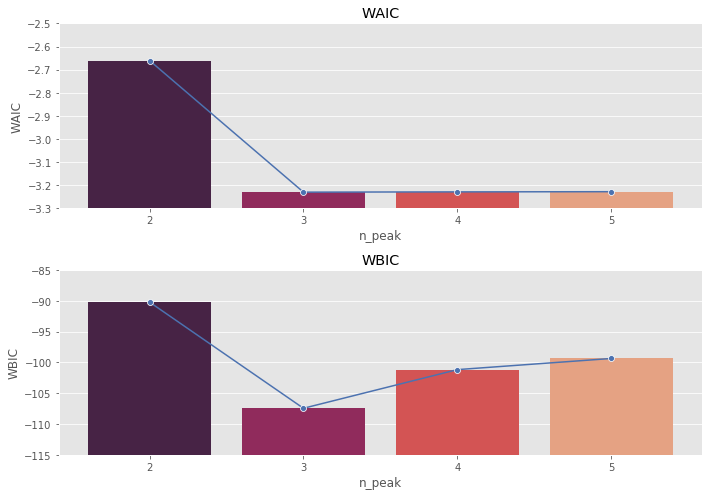

In [16]:
### matplotlib figureの準備
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 7))#, sharex=True)

### WAIC
# ベースライン調整
baseline_waic = 4
tempDf_waic = df_waic.copy()
tempDf_waic["WAIC"] += baseline_waic
# plot WAIC-values
ax1.set_title('WAIC')
sns.barplot(x = "n_peak", y = "WAIC", palette="rocket",data=tempDf_waic, ax=ax1, bottom=-baseline_waic)
sns.lineplot(x=[0,1,2,3], y = "WAIC", palette="rocket",data=df_waic, ax=ax1, marker="o")
ax1.set_xlabel('n_peak')
ax1.set_ylim([-3.3,-2.5])

### WBIC
# ベースライン調整
baseline_wbic = 150
tempDf_wbic = df_wbic.copy()
tempDf_wbic["WBIC"] += baseline_wbic
# plot WBIC-values
ax2.set_title("WBIC")
sns.barplot(x = "n_peak", y = "WBIC", palette="rocket",data=tempDf_wbic, ax=ax2, bottom=-baseline_wbic)
sns.lineplot(x=[0,1,2,3], y = "WBIC", palette="rocket",data=df_wbic, ax=ax2, marker="o")
ax2.set_xlabel('n_peak')
ax2.set_ylim([-115, -85])

plt.tight_layout()

*[図]上段：候補となるモデル（ピーク本数）に対するWAIC値, 下段：〃に対するWBIC値*

## 6. まとめ
- iterを多めに取った以前の実験とは異なり、WAIC・WBIC共にピーク本数＝３で最小値を取った。
- WAIC最小となるモデルはn_peak=5からn_peak=3に変わったが、その差はかなり小さく、MCMCのサンプリングの影響の範囲と考えられる。
- WBICは変わらず真の本数を選択できており、この問題に対しさほどのサンプリングは要さないと考えられる。
  - 真のモデルを選択する類の問題には、一致性を持つWBICを用いるのが適当である。